# MIMIC-III Model Generator
Generates a model based on MIMIC-III data to compute probabilities of transfering between departments as well as the average time spent in the department.
This model will then be run through with input data.

If the input data is the MIMIC-III original data, it should produce similar results to the real life situation with the difference resulting the approximation caused by the removal of both diagnostic data and the real patient history.

## Imports & Constants

In [1]:
import json
import random
import pickle
from math import isnan
import numbers
import pandas as pd
import numpy as np
from numpy.random import choice
from dateutil import relativedelta
import statistics
from sklearn.metrics import mean_squared_error

from plotnine import *
%matplotlib inline

## Process MIMIC-III Dataset

### Import MIMIC-III data & Basic processing

The dataframe is imported from a csv export of a basic SQL query run against the Postgres version of MIMIC-III:

```sql
SELECT *,
       (SELECT string_agg(icd9_code, ',') FROM mimiciii.diagnoses_icd d WHERE d.hadm_id = t.hadm_id) AS icd9
FROM mimiciii.transfers t
JOIN mimiciii.admissions a ON a.hadm_id = t.hadm_id
JOIN mimiciii.patients p ON p.subject_id = a.subject_id
;
```

In [2]:
# This is imported from the result of an SQL query on the imported version of the
df = pd.read_csv('../sql/SELECT_____________SELECT_string_agg_icd.csv')

In [ ]:
df

In [4]:
# Convert dates
df['intime'] = pd.to_datetime(df['intime'], format='%Y-%m-%d %H:%M:%S')
df['outtime'] = pd.to_datetime(df['outtime'], format='%Y-%m-%d %H:%M:%S')
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d %H:%M:%S')
df['admittime'] = pd.to_datetime(df['intime'], format='%Y-%m-%d %H:%M:%S')

### Exploring the MIMIC-III data

In [ ]:
df.head()

In [ ]:
df.describe()

In [7]:
# Distinct care units
df['curr_careunit'].unique()

array(['MICU', nan, 'SICU', 'TSICU', 'CSRU', 'CCU', 'NICU', 'NWARD'],
      dtype=object)

In [8]:
df['prev_careunit'].unique()

array([nan, 'MICU', 'SICU', 'TSICU', 'CSRU', 'CCU', 'NICU', 'NWARD'],
      dtype=object)

In [9]:
# Distinct Wards
df['curr_wardid'].unique()

array([52., 29., nan, 50., 45., 54., 15., 51., 36., 33., 14.,  2., 49.,
       32.,  8., 12., 27., 24., 40., 23., 37.,  7., 56., 43.,  5., 55.,
        4., 48., 17.,  3., 18., 57., 31., 26.,  9., 28., 30., 47., 41.,
       25., 44., 22., 10., 35., 16., 42., 38., 34.,  6., 39., 13., 20.,
       19., 11.])

In [10]:
# Distinct Admissions
len(df['hadm_id'].unique())

58976

### Group and process transfers
Group transfers by admission id (so that all transfers fall from it) and condense the records to the data we need.

In [11]:
df_by_admission_id = df.groupby(by="hadm_id")

In [12]:
def analyze_transfers(group):
    history = {}
    for index, row in group.iterrows():
        history[row['intime']] = {
            'eventtype': row['eventtype'],
            'curr_careunit': row['curr_careunit'],
            'prev_careunit': row['prev_careunit'],
            'prev_ward': row['prev_wardid'],
            'curr_ward': row['curr_wardid'],
            'wardid': row['curr_wardid'],
            'intime': row['intime'],
            'outtime': row['outtime']
        }

    return history

In [13]:
processed = []
for name, group in df_by_admission_id:
    admission_loc = [item for key, item in group["admission_location"].items()][0]
    discharge_loc = [item for key, item in group["discharge_location"].items()][0]
    admission_time = [item for key, item in group["admittime"].items()][0]
    dob = [item for key, item in group["dob"].items()][0]
    gender = [item for key, item in group["gender"].items()][0]
    
    try:
        age = relativedelta.relativedelta(admission_time, dob).years
    except:
        continue
    if age >= 65:
        age_range = 65
    elif age >= 25:
        age_range = 25
    elif age >= 15:
        age_range = 15
    else:
        age_range = 0
    
    
    processed.append({
        "admission_location": admission_loc,
        "discharge_location": discharge_loc,
        "gender": gender,
        "transfers": analyze_transfers(group),
        "dob": dob,
        "age_range": age_range,
        "admission_time": admission_time
    })

In [14]:
len(processed)

58952

In [ ]:
processed[0]

In [ ]:
processed[72]

### Export results
Export results to pickle and json for intermediate processing.

In [17]:
# Dump to pickle file
with open('processed.pickle', 'wb') as f:
    pickle.dump(processed, f, pickle.HIGHEST_PROTOCOL)

# Needs to be updated

# Dump to json file
# json_objects = {}
# for hadm_id, admission in objects.items():
#     record = {}
#     for timestamp, transfer in admission.items():
#         record[str(timestamp)] = transfer
#     json_objects[hadm_id] = record
# with open('processed_transfers.json', 'w') as f:
#     json.dump(json_objects, f)

### Compute counts

In [18]:
def record_transfer_prob(transfer_from, transfer_to, gender, age_range, arrival_hour):
    if transfer_from not in counts:
        counts[transfer_from] = {}
    
    if age_range not in counts[transfer_from]:
        counts[transfer_from][age_range] = {}
    
    if gender not in counts[transfer_from][age_range]:
        counts[transfer_from][age_range][gender] = {}
        
    if arrival_hour not in counts[transfer_from][age_range][gender]:
        counts[transfer_from][age_range][gender][arrival_hour] = {}
    
    # Actually commit the transfer
    if transfer_to not in counts[transfer_from][age_range][gender][arrival_hour]:
        counts[transfer_from][age_range][gender][arrival_hour][transfer_to] = 1
    else:
        counts[transfer_from][age_range][gender][arrival_hour][transfer_to] += 1

In [19]:
def combine_careunit(careunit, ward):
    return "{}_{}".format(
        ward,
        "OUTSIDE ICU" if (isinstance(careunit, numbers.Number) and isnan(careunit)) else careunit
    )

In [21]:
# counts
counts = {}
skipped = []
skipped_b = []
admissions = 0
same_transfers = []

for record in processed:
    # Extract record
    admission_location = record["admission_location"]
    discharge_location = record["discharge_location"]
    gender = record["gender"]
    transfers = record["transfers"]
    dob = record["dob"]
    age_range = record["age_range"]
    admission_time = record["admission_time"]
    
    # Process transfers
    transfers_items = list(record["transfers"].items())
    
    # Extract admission
    admission_transfer = transfers_items[0]
    discharge_transfer = transfers_items[-1]
    transfers_to_process = transfers_items[1:-1]
    
    # Record admission
    record_transfer_prob(
        admission_location,
        combine_careunit(admission_transfer[1]["curr_careunit"], admission_transfer[1]["curr_ward"]),
        gender, 
        age_range, 
        admission_time.hour
    )
    
    # Record transfers
    last_unit = combine_careunit(admission_transfer[1]["curr_careunit"], admission_transfer[1]["curr_ward"])
    
    for timestamp, transfer in transfers_to_process:
        transfer_to = combine_careunit(transfer["curr_careunit"], transfer["curr_ward"])
        transfer_from = last_unit
        record_transfer_prob(transfer_from, transfer_to, gender, age_range, admission_time.hour)
        last_unit = transfer_to
        
    # Record discharge
    record_transfer_prob(
        last_unit,
        discharge_location,
        gender, 
        age_range, 
        admission_time.hour
    )
    
#     # Process transfers
#     for timestamp, transfer in record["transfers"].items():
#         event_type = transfer["eventtype"]
#         care_unit = transfer["careunit"]
        
#         if event_type == "admit":
#             admissions += 1
#             transfer_from = admission_loc
# #             if not care_unit:
# #                 continue
#             if (isinstance(care_unit, numbers.Number) and isnan(care_unit)):
#                 transfer_to = "OUTSIDE ICU"
#                 # continue
#             else:
#                 transfer_to = care_unit
#         elif event_type == "discharge":
#             transfer_from = last_transfer_from
#             transfer_to = discharge_loc
#         elif care_unit and (not isinstance(care_unit, numbers.Number) or not isnan(care_unit)):
#             transfer_from = last_transfer_from
#             transfer_to = care_unit
#         else:
#             # Skip if within same unit (ward transfer)
#             skipped_b.append(transfer)
#             continue
        
#         if transfer_from != transfer_to:
#             record_transfer_prob(transfer_from, transfer_to, gender, age_range, admission_time.hour)
#         else:
#             same_transfers.append(transfer)
            
#         # Keep track of name of last unit
#         if care_unit:
#             last_transfer_from = transfer_to
#         else:
#             last_transfer_from = transfer_to

In [22]:
a = [record["admission_location"] for record in processed]

In [ ]:
set(a)

In [ ]:
counts.keys()

In [ ]:
counts

### Explore counts

In [26]:
accumulator = 0
for transfer_from, transfer_from_items in counts.items():
    for age_range, age_range_items in transfer_from_items.items():
        for gender, gender_items in age_range_items.items():
            for admission_hour, admission_hour_items in gender_items.items():
                accumulator += sum(admission_hour_items.values())
accumulator

261803

In [27]:
percent_of_transfers_used = accumulator / df.shape[0]
percent_of_transfers_used

0.9996410802720154

### Compute probabilities

In [28]:
probabilities = {
    transfer_from: {
        age_range: {
            gender: {
                admission_hour: {
                    transfer_to: count/sum(admission_hour_items.values()) for transfer_to, count in admission_hour_items.items()
                } for admission_hour, admission_hour_items in gender_items.items()
            } for gender, gender_items in age_range_items.items()
        } for age_range, age_range_items in transfer_from_items.items()
    } for transfer_from, transfer_from_items in counts.items()
}

### Export probabilities

In [29]:
with open("../json/probabilities.json", "w") as f:
    json.dump(probabilities, f)

## Compute durations

### Extract durations

In [30]:
def record_transfer_duration(transfer_from, gender, age_range, arrival_hour, duration):
    if transfer_from not in durations:
        durations[transfer_from] = {}
    
    if age_range not in durations[transfer_from]:
        durations[transfer_from][age_range] = {}
    
    if gender not in durations[transfer_from][age_range]:
        durations[transfer_from][age_range][gender] = {}
        
    if arrival_hour not in durations[transfer_from][age_range][gender]:
        durations[transfer_from][age_range][gender][arrival_hour] = []
        
    durations[transfer_from][age_range][gender][arrival_hour].append(duration)

In [31]:
# durations
durations = {}

for record in processed:
    # Extract record
    admission_location = record["admission_location"]
    discharge_location = record["discharge_location"]
    gender = record["gender"]
    transfers = record["transfers"]
    dob = record["dob"]
    age_range = record["age_range"]
    admission_time = record["admission_time"]
    
    # Process transfers
    transfers_items = list(record["transfers"].items())
    
    # Extract admission
    admission_transfer = transfers_items[0]
    discharge_transfer = transfers_items[-1]
    transfers_to_process = transfers_items[1:-1]
    
    # Record admission
    try:
        record_transfer_duration(
            admission_location,
            gender, 
            age_range, 
            admission_time.hour,
            relativedelta.relativedelta(admission_transfer[1]["outtime"], admission_transfer[1]["intime"])
        )
    except:
        continue
    
    # Record transfers
    last_unit = combine_careunit(admission_transfer[1]["curr_careunit"], admission_transfer[1]["curr_ward"])
    
    for timestamp, transfer in transfers_to_process:
        in_time = transfer["intime"]
        out_time = transfer["outtime"]
        
        try:
            duration = relativedelta.relativedelta(out_time, in_time)
        except:
            continue
        
        transfer_to = combine_careunit(transfer["curr_careunit"], transfer["curr_ward"])
        transfer_from = last_unit
        record_transfer_duration(transfer_from, gender, age_range, admission_time.hour, duration)
        last_unit = transfer_to
        
    # Record discharge
    # No record is done!
    
    
#     # Process transfers
#     for timestamp, transfer in record["transfers"].items():
#         event_type = transfer["eventtype"]
#         care_unit = transfer["prev_careunit"]
#         care
#         in_time = transfer["intime"]
#         out_time = transfer["outtime"]
        
        
#         try:
#             duration = relativedelta.relativedelta(out_time, in_time)
#         except:
#             continue
        
        
#         if event_type == "admit":
#             if not care_unit or (isinstance(care_unit, numbers.Number) and isnan(care_unit)):
#                 continue
#             transfer_from = admission_loc
#             transfer_to = care_unit
#         elif event_type == "discharge":
#             transfer_from = last_transfer_from
#             transfer_to = discharge_loc
#         elif care_unit and (not isinstance(care_unit, numbers.Number) or not isnan(care_unit)):
#             transfer_from = last_transfer_from
#             transfer_to = care_unit
#         else:
#             # Skip if within same unit (ward transfer)
#             continue
        
#         if transfer_from != transfer_to:
#             record_transfer_duration(transfer_from, gender, age_range, admission_time.hour, duration)
            
#         # Keep track of name of last unit
#         if care_unit:
#             last_transfer_from = care_unit

### Explore durations

### Compute medians

In [32]:
def total_seconds(rd, _yeardays=365.2425, _monthdays=365.2425/12):
    """approximation of the number of seconds in a relative delta"""
    # year and month durations are averages, taking into account leap years
    total_days = rd.years * _yeardays + (rd.months * _monthdays) + rd.days
    total_hours = total_days * 24 + rd.hours
    total_minutes = total_hours * 60 + rd.minutes
    return total_minutes * 60 + rd.seconds + (rd.microseconds / 1000000)

In [33]:
median_durations = {
    transfer_from: {
        age_range: {
            gender: {
                admission_hour: statistics.median([total_seconds(value) for value in admission_hour_items])
                for admission_hour, admission_hour_items in gender_items.items()
            } for gender, gender_items in age_range_items.items()
        } for age_range, age_range_items in transfer_from_items.items()
    } for transfer_from, transfer_from_items in durations.items()
}

### Export median durations

In [34]:
with open("../json/median_durations.json", "w") as f:
    json.dump(median_durations, f)

## Create Model

### Examine possible states

In [ ]:
possible_states = list(probabilities.keys())
for from_state, from_items in probabilities.items():
    for age, age_items in from_items.items():
        for gender, gender_items in age_items.items():
            for arrival_hour, arrival_hour_items in gender_items.items():
                possible_states.extend(arrival_hour_items.keys())
possible_states = set(possible_states)
possible_states

In [36]:
# print(json.dumps(probabilities))

In [ ]:
{ age_range: { gender: { arrival_hour: duration/3600 for arrival_hour, duration in gender_items.items()}
  for gender, gender_items in age_range_items.items()}
 for age_range, age_range_items in median_durations["27.0_OUTSIDE ICU"].items()}

## Prepare inputs to model

### Import raw inputs

In [38]:
# Import inputs
df = pd.read_csv('../sql/SELECT_____________SELECT_string_agg_icd.csv')
df['admittime'] = pd.to_datetime(df['intime'], format='%Y-%m-%d %H:%M:%S')
df['intime'] = pd.to_datetime(df['intime'], format='%Y-%m-%d %H:%M:%S')
df['outtime'] = pd.to_datetime(df['outtime'], format='%Y-%m-%d %H:%M:%S')
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d %H:%M:%S')

df_by_hadm = df.groupby(by="hadm_id")


processed_inputs = []
for name, group in df_by_admission_id:
    admission_loc = [item for key, item in group["admission_location"].items()][0]
    discharge_loc = [item for key, item in group["discharge_location"].items()][0]
    admission_time = [item for key, item in group["admittime"].items()][0]
    dob = [item for key, item in group["dob"].items()][0]
    gender = [item for key, item in group["gender"].items()][0]
    
    try:
        age = relativedelta.relativedelta(admission_time, dob).years
    except:
        continue
    if age >= 65:
        age_range = 65
    elif age >= 25:
        age_range = 25
    elif age >= 15:
        age_range = 15
    else:
        age_range = 0
    
    
    processed_inputs.append({
        "admission_location": admission_loc,
        "gender": gender,
        "age_range": age_range,
        "admission_hour": admission_time.hour
    })

inputs = processed_inputs

In [39]:
len(inputs)

58952

### Group inputs by time

In [40]:
grouped_inputs = {}
for processed_input in processed_inputs:
    admission_hour = processed_input["admission_hour"]
    
    if admission_hour not in grouped_inputs:
        grouped_inputs[admission_hour] = []
        
    grouped_inputs[admission_hour].append(processed_input)

In [41]:
len(grouped_inputs)

24

## The Model

### Prepare initial state of model

In [42]:
def fetch_median_departure(median_durations, item):
    return median_durations[item['admission_location']][item['age_range']][item['gender']][item['admission_hour']] / 3600

def fetch_next_transition(probabilities, item, location):
    transition_probabilities = probabilities[location][item['age_range']][item['gender']][item['admission_hour']]
#     print(item)
#     print("choices: {}. weights: {}".format(
#         list(transition_probabilities.keys()), 
#         list(transition_probabilities.values())
#     ))
    state_next = random.choices(
        list(transition_probabilities.keys()),
        weights=list(transition_probabilities.values()),
        k=1
    )[0]
    
    return state_next

In [43]:
t_prob = probabilities["52.0_MICU"][15]["F"][4]

In [ ]:
random.choices(
        list(t_prob.keys()),
        weights=list(t_prob.values()),
        k=100
    )

In [45]:
timeslot = 0
timeslots = []
wip = {}
#MAX_TIMESLOTS = 1000
MAX_DAYS = 14
MAX_TIMESLOTS = MAX_DAYS * 24

In [46]:
#test_grouped_inputs = {0: [grouped_inputs[0][0]]}
#test_grouped_inputs
test_grouped_inputs = grouped_inputs

### Run the Model

In [47]:
# with open('timeslots.pickle', 'rb') as f:
#     timeslots = pickle.load(f, pickle.HIGHEST_PROTOCOL)

In [ ]:
while True:
    items_in_model = sum([len(item) for item in wip.values()])
    print ("Timeslot: {}. # of items in model: {}. {}.".format(
        timeslot,
        items_in_model,
        'No inputs to process' if timeslot not in grouped_inputs else 'Inputs to process'
    ))

    new_wip = {}
    
    # Track progress
    changed_counter = 0
    unchanged_counter = 0
    frozen_counter = 0
    added_counter = 0
    processed_counter = 0

    # Handle inputs

    if timeslot in test_grouped_inputs:
        for input_item in test_grouped_inputs[timeslot]:
            admission_location = input_item['admission_location']
            if admission_location not in new_wip:
                new_wip[admission_location] = []
            added_counter = added_counter + 1
            new_wip[admission_location].append((input_item, timeslot))

    # Process records in dataset!

    for location, items in wip.items():
        for item, arrival_timeslot in items:
            # Process each item from previous state of model
            processed_counter += 1
            median_departure_timeslot = fetch_median_departure(median_durations, item)

            # Should it depart?
            if (arrival_timeslot + median_departure_timeslot) <= timeslot:
                # Depart!
                
                try:
                    state_next = fetch_next_transition(probabilities, item, location)
                    changed_counter += 1
                except:
                    frozen_counter += 1
                    state_next = location

                # Move to next step
                if state_next not in new_wip:
                    new_wip[state_next] = []
                new_wip[state_next].append((item, timeslot))
                
            else:
#                 print("arrival: {}; median: {}; combined: {}; current: {}; location: {}".format(
#                     arrival_timeslot,
#                     median_departure_timeslot,
#                     arrival_timeslot + median_departure_timeslot,
#                     timeslot,
#                     location
#                 ))
                
                # Keep it in place
                unchanged_counter += 1
                if location not in new_wip:
                    new_wip[location] = []
                new_wip[location].append((item, arrival_timeslot))

    # Report changes summary
    print("\tProcessed {}. Changed: {} ({}). Frozen: {} ({}). Unchanged: {} ({}). Added: {} ({}).".format(
        processed_counter,
        changed_counter, round(changed_counter/items_in_model, 2) if items_in_model > 0 else 0,
        frozen_counter, round(frozen_counter/items_in_model, 2) if items_in_model > 0 else 0,
        unchanged_counter, round(unchanged_counter/items_in_model, 2) if items_in_model > 0 else 0,
        added_counter, round(added_counter/items_in_model, 2) if items_in_model > 0 else 0,
    ))
    print ()
    
    # Next timeslot!
    timeslots.append(new_wip.copy())
    timeslot += 1
    wip = new_wip.copy()

    # Break the cycle!
    if timeslot == MAX_TIMESLOTS:
        break

### Run model

In [49]:
len(timeslots)

336

In [50]:
track_changes = []
track_changes_summary = []

# Initial slot
track_changes.append({key: len(items) for key, items in timeslots[0].items()})
track_changes_summary.append(sum([len(items) for key, items in timeslots[0].items()]))

# Subsequent slots
for i, items in enumerate(zip(timeslots[1:], timeslots)):
    timeslot_differences = {}
    
    timeslot = i
    curr_items, prev_items = items
    keys = set(curr_items.keys())
    keys |= set(prev_items.keys())
    for key in keys:
        curr_count = len(curr_items.get(key, []))
        prev_count = len(prev_items.get(key, []))
        difference = curr_count - prev_count
        
        timeslot_differences[key] = difference
        
    track_changes.append(timeslot_differences)
    track_changes_summary.append(sum([abs(count) for key, count in timeslot_differences.items()]))

In [ ]:
track_changes_summary

In [52]:
condensed_timeslots = {timeslot: {label: len(items) for label, items in timeslot_items.items()} 
 for timeslot, timeslot_items in enumerate(timeslots)}

In [ ]:
track_changes

In [54]:
last_slot = list({timeslot: {label: len(items) for label, items in timeslot_items.items()} 
 for timeslot, timeslot_items in enumerate(timeslots)}.items())[-1]

In [ ]:
[(place, count/sum(last_slot[1].values())) for place, count in sorted(last_slot[1].items(), key=lambda x: x[1], reverse=True)]

## Prepare Visualization

In [56]:
visualization_input_locations = {input['admission_location'] for input in inputs}
visualization_input_locations

{'** INFO NOT AVAILABLE **',
 'CLINIC REFERRAL/PREMATURE',
 'EMERGENCY ROOM ADMIT',
 'HMO REFERRAL/SICK',
 'PHYS REFERRAL/NORMAL DELI',
 'TRANSFER FROM HOSP/EXTRAM',
 'TRANSFER FROM OTHER HEALT',
 'TRANSFER FROM SKILLED NUR',
 'TRSF WITHIN THIS FACILITY'}

In [57]:
destination_locations = possible_states - visualization_input_locations
# destination_locations

In [58]:
exit_locations = destination_locations - set(probabilities.keys())
# exit_locations

In [59]:
intermediate_locations = destination_locations - exit_locations
# intermediate_locations

In [60]:
# Combine & export
locations = {
    'admission_locations': list(visualization_input_locations),
    'discharge_locations': list(exit_locations),
    'intermediate_locations': list(intermediate_locations)
}

with open("locations.json", "w") as f:
    json.dump(locations, f)

In [61]:
with open('timeslots.pickle', 'wb') as f:
    pickle.dump(timeslots, f, pickle.HIGHEST_PROTOCOL)

In [62]:
timeslots_summary = [{location: len(items) for location, items in timeslot.items()} for timeslot in timeslots]

In [63]:
with open("timeslots_summary.json", "w") as f:
    json.dump(timeslots_summary, f)

In [64]:
inputs_count = {}
for row in inputs:
    if row["admission_location"] not in inputs_count:
        inputs_count[row["admission_location"]] = 0
    inputs_count[row["admission_location"]] += 1

with open("inputs_count.json", "w") as f:
    json.dump(inputs_count, f)

## Validation

In [65]:
processed_records = 0
failed_records = 0
success_records = 0

In [88]:
print("failed: {}, success: {}, processed: {}".format(failed_records, success_records, processed_records))

failed: 702, success: 200896, processed: 202371


In [67]:
# def record_offsets(admission_time, start_time, end_time, location):
def record_offsets(admission_time, start_time, end_time, location):
    global failed_records
    global success_records
    global processed_records
    processed_records += 1
    arrival_intime = relativedelta.relativedelta(start_time, admission_time)
    intime_outtime = relativedelta.relativedelta(end_time, start_time)
    start_slot = arrival_intime.months * 30 * 24 + arrival_intime.days * 24 + arrival_intime.hours + admission_time.hour
    end_slot = intime_outtime.months * 30 * 24 + intime_outtime.days * 24 + intime_outtime.hours + start_slot
    
    if start_slot < 0 or end_slot < 0:
        print("Start: {}. End: {}. Location: {}".format(start_slot, end_slot, location))
        print(admission_time)
        print(start_time)
        failed_records += 1
        return False
    else:
        success_records  += 1

    for timeslot in range(start_slot, end_slot):
        if timeslot not in validate_timeslots:
            validate_timeslots[timeslot] = {}
        if location not in validate_timeslots[timeslot]:
            validate_timeslots[timeslot][location] = 0
        validate_timeslots[timeslot][location] += 1
    
    return True
        

In [ ]:
# durations
validate_timeslots = {}

for record in processed:
    transfers = record["transfers"]
    admission_time = record["admission_time"]
    admission_location = record["admission_location"]
    
    # Process transfers
    transfers_items = list(record["transfers"].items())
    
    # Extract admission
    admission_transfer = transfers_items[0]
    discharge_transfer = transfers_items[-1]
    transfers_to_process = transfers_items[1:-1]
    
    # Record admission
    result = False
    try:
        result = record_offsets(
            admission_time,
            admission_time,
            admission_transfer[1]["outtime"],
            admission_location
        )
    except:
        continue
        
    if not result:
        continue

#     record_offsets(
#         admission_time,
#         admission_time,
#         admission_transfer[1]["outtime"],
#         admission_location,
#         validate_timeslots,
#         failed_records,
#         success_records
#     )
    
    # Record transfers
    last_unit = combine_careunit(admission_transfer[1]["curr_careunit"], admission_transfer[1]["curr_ward"])
    
    for timestamp, transfer in transfers_to_process:
        in_time = transfer["intime"]
        out_time = transfer["outtime"]
        
        
        transfer_to = combine_careunit(transfer["curr_careunit"], transfer["curr_ward"])
        transfer_from = last_unit
        
        try:
            record_offsets(
                admission_time,
                in_time,
                out_time,
                transfer_from
            )
        except:
            continue
        last_unit = transfer_to
        
    
#     # Record discharge
#     if out_time.hour not in validate_timeslots:
#         validate_timeslots[out_time.hour] = {}
#     if location not in validate_timeslots[out_time.hour]:
#         validate_timeslots[out_time.hour][discharge_location] = 0
#     validate_timeslots[out_time.hour][discharge_location] += 1

###### len(validate_timeslots)

In [ ]:
validate_timeslots.keys()

In [70]:
validate_timeslots[max(validate_timeslots.keys())]

{'2.0_OUTSIDE ICU': 1}

In [ ]:
validate_timeslots[1]

## MSE

In [72]:
len(condensed_timeslots)

336

In [73]:
len(validate_timeslots)

7647

In [ ]:
condensed_timeslots[0]

In [ ]:
validate_timeslots[0]

In [76]:
mses = []

In [ ]:
possible_states_mapping = dict(enumerate(possible_states))
possible_states_mapping

In [78]:
for counter, timeslots in enumerate(zip(condensed_timeslots.values(), validate_timeslots.values())):
    model_timeslot, validated_timeslot = timeslots
    model_all_states = []
    validated_all_states = []
    for state in possible_states:
        model_state = model_timeslot.get(state, 0)
        validated_state = validated_timeslot.get(state, 0)
        model_all_states.append(model_state)
        validated_all_states.append(validated_state)
    
    mses.append(mean_squared_error(validated_all_states, model_all_states))

In [ ]:
[mse**0.5 for mse in mses]

In [80]:
temp_dict = {i: mse for i, mse in enumerate(mses)}

In [81]:
validation_df = pd.DataFrame.from_dict({'Timeslot': list(temp_dict.keys()), 'MSE': list(temp_dict.values())})

In [ ]:
validation_df

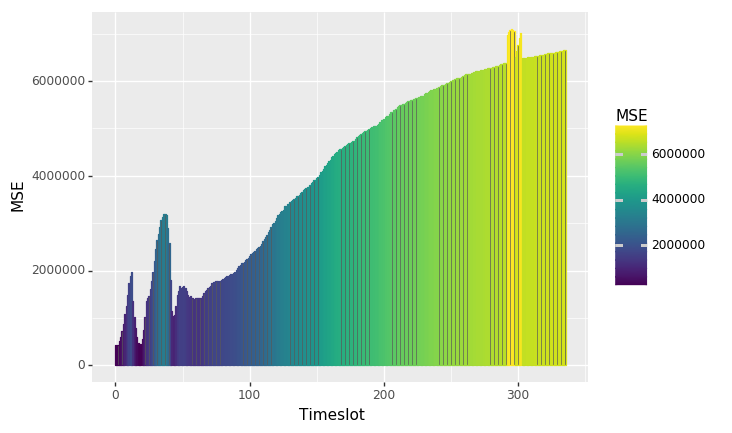

<ggplot: (-9223363257899201080)>

In [83]:
(
    ggplot(validation_df, aes('Timeslot', 'MSE', color='MSE'))
    + geom_col()
)

In [86]:
validation_root_df = pd.DataFrame.from_dict({'Timeslot': list(temp_dict.keys()), 'RMSE': [mse**0.5 for mse in list(temp_dict.values())]})

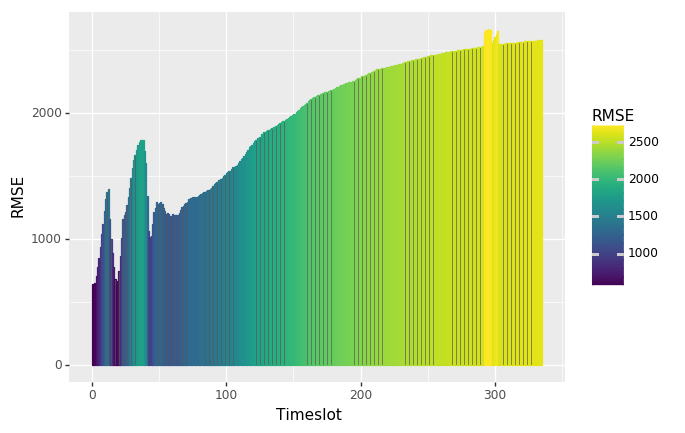

<ggplot: (8778956482024)>

In [87]:
(
    ggplot(validation_root_df, aes('Timeslot', 'RMSE', color='RMSE'))
    + geom_col()
)